# Loss Functions Part 2

> "In this part of the multi-part series on the loss functions we'll be taking a look at MSE, MAE, Huber Loss, Hinge Loss, and Triplet Loss. We'll also look at the code for these Loss functions in PyTorch and some examples of how to use them"

- toc: true
- branch: fastbook/lessons
- badges: true
- comments: true
- image: images/triplet_loss.png
- categories: [loss_functions]
- hide: false
- author: Akash Mehra

In [111]:
#collapse-hide
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt
precision=4
np.set_printoptions(precision=precision)

In this post, I'd like to ensure that we're able to code the loss classes ourselves as well, that means that we'll need to be able to:

1. Translate the equations to Python code for `forward` pass.
2. Know how to calculate the gradients for a few loss functions, so that when we call `backward` pass the gradients get accumulated.

Note that in presence of `autodiff` or `autograd` we won't need to do such a thing and this is purely for learning perspective, better implementations are offered by Deep Learning Libraries like `PyTorch`, `Tensorflow` etc.

So, we'll define a class called `Module` that we'll use and override its `forward` and `backward` *abstract* functions 

In [16]:
from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self, reduction='mean'):
        self.grad_input = None
        self.reduction = reduction

    def __call__(self, input, target):
        return self.forward(input, target)
    
    @abstractmethod
    def forward(*args, **kwargs):
        pass
    
    @abstractmethod
    def backward(*args, **kwargs):
        pass
    
    def update_grad_input(self, grad):
        if self.grad_input is not None:
            self.grad_input += grad
        else:
            self.grad_input = grad
    
    def zero_grad(self):
        if self.grad_input is not None:
            self.grad_input = np.zeros_like(self.grad_input)

After having setup our *base* class, we can now look at individual Loss functions and start coding them.

## Mean Squared Error

Mean Squared Error (MSE) measures the average of the squares of the errors for an estimator. The MSE of an estimator $\hat{\theta}$​ wrt an unknown parameter $\theta$​ is defined as $MSE(\hat{\theta})  =E[(\hat{\theta} - \theta)^2]$​​​. It can also be written as the sum of  *Variance* and the squared *Bias* of the estimator. In case of an *unbiased* estimator the *MSE* and *variance* are equivalent. Below is a quick way to see how the MSE and the Variance and Bias are related to each other.

$$
E[X] = \mu
$$

$$
Var(X) = E[(X - \mu)^2] = E[X^2] + \mu^2 - 2\mu E[X] \implies E[X^2] - E[X]^2
$$

using the following result:

$$
Var(X-Y) = Var(X) + Var(Y) - 2Cov(X,Y)
$$

$$
Var(\mu) = 0
$$

$$
Cov(X,\mu) = E[X-E[X]]E[\mu-E[\mu]] = 0 \implies Var(X-\mu) = Var(X)
$$

We arrive at:

$$
MSE(\hat{\theta}) = E[(\hat{\theta} - \theta)^2] \implies Var(\hat{\theta} - \theta) + E[\hat{\theta} - \theta]^2
$$

$$
MSE(\hat{\theta}) =  Var[\hat{\theta}] + Bias^2[\hat{\theta}]
$$


We can see from above that as *Variance,* *MSE* also heavily weights the outliers. It's squaring each term which weights large error terms more heavily than smaller ones. An alternative in that becomes *Mean Absolute Error* which is the topic of discussion of next section.

### MSE Loss in numpy

We're using our implementation of the `Module` class. We'll define `forward` and `backward` functions for *MSE* Loss

In [168]:
class MSELoss(Module):
    def __init__(self, reduction='mean'):
        super(MSELoss, self).__init__(reduction)
    
    def forward(self, input, target):
        if self.reduction is not None:
            red = getattr(np, self.reduction)
        else:
            red = np.asarray
        return np.asarray([red((target-input)**2),])
    
    def backward(self, input, target):
        N = np.multiply.reduce(input.shape)
        grad = (2/N * (input-target))
        self.update_grad_input(grad)

Forward pass using our Implementation

In [240]:
#collapse-hide

reduction = 'mean'
SEED=42
rs = np.random.RandomState(SEED)
input = rs.randn(3,2,4,5)
target = rs.randn(3,2,4,5)

mse = MSELoss(reduction)
loss = mse(input, target)
loss

array([1.7061])

Let's test our implementation against *PyTorch* and see if we've implemented things correctly or not.

### MSE Loss in PyTorch

Using the same input and target `numpy.ndarray` as `torch.tensor`

Forward pass using PyTorch's Implementation

In [241]:
#collapse-hide
criterion = nn.MSELoss(reduction=reduction)
inp = Variable(torch.from_numpy(input), requires_grad=True)
loss = criterion(inp, torch.from_numpy(target))
loss

tensor(1.7061, dtype=torch.float64, grad_fn=<MseLossBackward>)

Comparing gradients

In [242]:
#collapse-hide
loss.backward()
mse.backward(input, target)
np.allclose(mse.grad_input, inp.grad.numpy())

True

## Mean Absolute Error Loss (MAE)

As pointed out earlier the *MSE* Loss suffers in the presence of outliers and heavily weights them. *MAE* on the other hand is more robust in that scenario. It is defined as the average of the absolute differences between the predictions and the target values.

$$
MAE(\hat{\theta}) = (E[|\hat{\theta} - \theta|])
$$

It is also knows as the *L1Loss* as it is measuring the *L1* distance between two *vectors*

### MAE/L1 Loss in numpy

We'll use our implementation of the Module here as well and define the `forward` and `backward` function for `L1Loss`

In [243]:
class L1Loss(Module):
    def __init__(self, reduction='mean'):
        super(L1Loss, self).__init__(reduction)
    
    def forward(self, input, target):
        if self.reduction is not None:
            red = getattr(np, self.reduction)
        else:
            red = np.asarray
        return np.asarray([red((np.abs(target-input))),])
    
    def backward(self, input, target):
        N = np.multiply.reduce(input.shape)
        diff = input - target
        mask_lg = (diff > 0) * 1.0
        mask_sm = (diff < 0) * -1.0
        mask_zero = (diff == 0 ) * 0.0
        grad = 1/N * (mask_lg + mask_sm + mask_zero)
        self.update_grad_input(grad)

Forward pass using our Implementation

In [244]:
#collapse-hide
reduction = 'mean'
SEED=42
rs = np.random.RandomState(SEED)
input = rs.randn(3,2,4,5)
target = rs.randn(3,2,4,5)

l1loss = L1Loss(reduction)
l1loss(input, target)

array([1.0519])

As before, let's test our implementation against *PyTorch* and see if we've implemented things correctly or not.

### MAE/L1 Loss in PyTorch

Forward Pass using PyTorch's implementation

In [245]:
#collapse-hide
criterion = nn.L1Loss(reduction='mean')
inp = Variable(torch.from_numpy(input), requires_grad=True)
loss = criterion(inp, torch.from_numpy(target))
loss

tensor(1.0519, dtype=torch.float64, grad_fn=<L1LossBackward>)

Comparing gradients

In [246]:
#collapse-hide
loss.backward()
l1loss.backward(input, target)
np.allclose(l1loss.grad_input, inp.grad)

True

## Huber Loss
*Huber* Loss is used for Regression problems, it is more robust to outliers due to its form. 

> It combines the best properties of L2 squared loss and L1 absolute loss by being strongly convex when close to the target/minimum and less steep for extreme values

It is defined as: 

$$
\mathcal{L}_{\delta}(y, f(x)) = \begin{cases} 
\frac{1}{2} (y - f(x))^2, & \text{if $y - f(x) < \delta$} \\
\delta (|y - f(x)| - \frac{1}{2}\delta), & \text{otherwise}
\end{cases}
$$

### Huber Loss in numpy

We'll use our implementation of the Module here as well and define the `forward` and `backward` function for `HuberLoss`

Because *Huber* Loss truly is a combination of *L1* and *L2 (MSE)* Loss then we don't really need to reimplement anything, we just need to use the classes we;ve already implemented

In [247]:
class HuberLoss(Module):
    def __init__(self, reduction='mean', delta=1.0):
        super(HuberLoss, self).__init__(reduction)
        self.mse = MSELoss(reduction=None)
        self.l1 = L1Loss(reduction=None)
        self.delta = delta
    
    def forward(self, x, y):
        mask_sm = np.abs(y-x) < self.delta
        mask_lg = np.abs(y-x) >= self.delta
        first_term = 0.5 * self.mse(x,y) * mask_sm
        second_term = (self.delta * (self.l1(x,y) - 0.5 * self.delta)) * mask_lg
        red = getattr(np, self.reduction)
        return np.asarray([red(first_term + second_term)])
        
    def backward(self, x, y):
        mask_sm = np.abs(y-x) < self.delta
        mask_lg = np.abs(y-x) >= self.delta
        self.mse.backward(x,y)
        self.l1.backward(x,y)
        grad = 0.5 * self.mse.grad_input * mask_sm + \
            self.delta * self.l1.grad_input * mask_lg
        self.update_grad_input(grad)

Forward pass using our implementation

In [248]:
#collapse-hide
reduction = 'mean'
SEED=42
rs = np.random.RandomState(SEED)
input = rs.randn(3,5)
target = rs.randn(3,5)

huber = HuberLoss()
huber(input, target)

array([0.6369])

### Huber Loss in PyTorch


Forward pass using PyTorch's implementation

In [249]:
#collapse-hide
criterion = nn.HuberLoss(reduction='mean', delta=1.0)
inp = Variable(torch.from_numpy(input), requires_grad=True)
loss = criterion(inp, torch.from_numpy(target))
loss

tensor(0.6369, dtype=torch.float64, grad_fn=<HuberLossBackward>)

Comparing gradients

In [250]:
loss.backward()
huber.backward(input, target)
np.allclose(huber.grad_input, inp.grad)

True

Now, let's see how do these functions look when we plot them

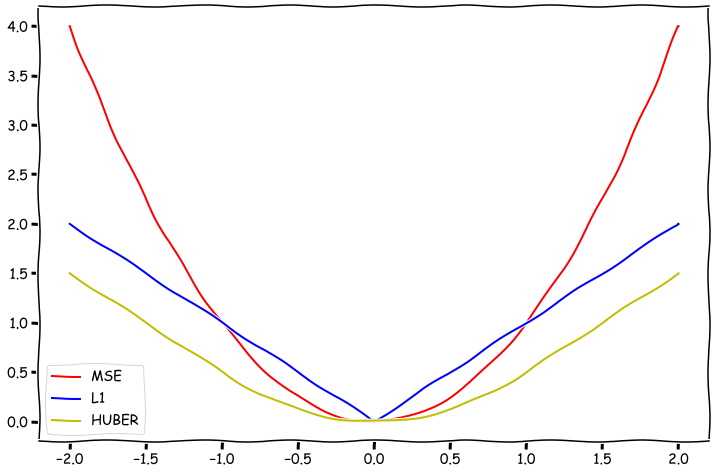

In [251]:
#collapse-hide

def mse(x):
    return x**2

def l1(x):
    return np.abs(x)

def huber(x, delta):
    mask_sm = np.abs(x) < delta
    mask_lg = np.abs(x) >= delta
    return (0.5 * x**2 * mask_sm) + \
            (delta * (np.abs(x) - 0.5 * delta) * mask_lg)

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,8))
    x = np.linspace(-2, 2, 1000)
    
    ax.plot(x,mse(x), color='r', label='MSE')
    ax.plot(x, l1(x), color='b', label='L1')
    ax.plot(x, huber(x, 1.0), color='y', label='HUBER')
    ax.legend()

## Hinge Loss

*Hinge* loss is used for training classifiers. The *hinge* loss is used for "maximum-margin" classification, most notably for support vector machines.

For an intended output $y_{target}$ = ±1 and a classifier score $y_{pred}$, the hinge loss of the prediction $y_{pred}$ is defined as:

$$
\mathcal{L}(y_{pred}) = \max(0, 1 - y_{target} . y_{pred})
$$

This form can. be coded using `numpy` as follows:

In [80]:
def hinge_vectorized(x,y):
    mask = np.ones(x.shape[0], bool)
    mask[y] = False
    repeated = np.repeat(x[y], x.shape[0]-y.shape[0], axis=1).T
    zeros = np.zeros_like(repeated)
    appended = np.append(zeros, 1 - (repeated - x[mask]), axis=1)
    return np.asarray([np.sum(1.0/(x.shape[0]) * np.max(appended, axis=1))])

*Hinge* Loss is convex function, but the form shown above isn't differentiable but it has a subgradient wrt to the model parameters $\mathbb{w}$ of a linear *SVM* with score function given by $ y = \mathbb{w} . x$:

$$
\frac{\partial{\mathcal{L}}}{\partial{\mathbb{w}}} = \begin{cases}
    -y_{pred}.x, & \text{if $y_{pred} . x <1$}\\
    0, & \text{otherwise}
\end{cases}
$$

the gradient for $y_{pred} .x = 1$ does't exist so a smotthed version of the hinge loss is preferred for implementations

$$
\mathcal{L}(y_{pred}) = \begin{cases} 
\frac{1}{2\gamma} \max(0, 1 - y_{target} .y_{pred})^2, & \text{if $y_{target} . y_{pred} \geq 1 - \gamma$} \\
1 - \frac{\gamma}{2} - y_{target} . y_{pred}, & \text{otherwise}
\end{cases}
$$

if we were to plot the *Hinge* Loss using the equations of two variants we just looked at then it's look somethng like the following:

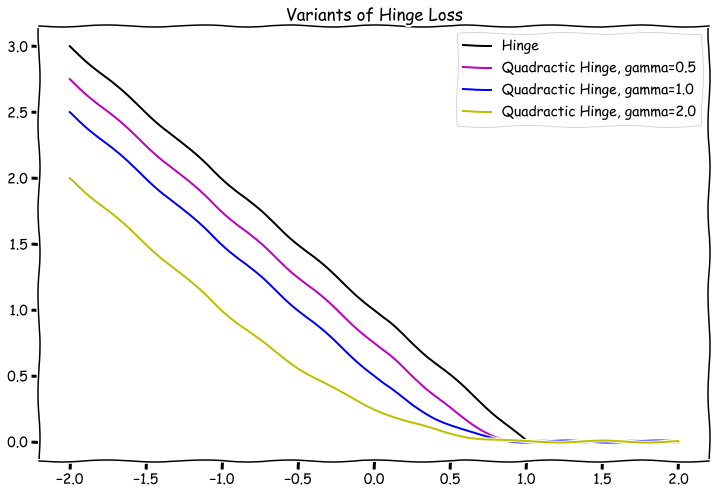

In [124]:
#collapse-hide

def hinge(y):
    appended = np.append(np.zeros_like(y), 1-y, axis=1)
    return np.max(appended, axis=1, keepdims=True)

def hinge_quadratic(x, gamma=1.0):
    appended = np.append(np.zeros_like(x), 1-x, axis=1)
    func_1 = 1/(2. * gamma) * np.max(appended, axis=1, keepdims=True)**2
    func_2 = 1-gamma/2.0-x
    mask_geq = (x >= (1-gamma)) * 1.0
    mask_sm = (x < (1-gamma)) * 1.0
    return func_1 * mask_geq + func_2 * mask_sm

with plt.xkcd():
    fig, ax = plt.subplots(figsize=(12,8))
    x = np.linspace(-2, 2, 1000).reshape(-1,1)
    
    ax.plot(x,hinge(x), color='black', label='Hinge')
    ax.plot(x, hinge_quadratic(x, gamma=0.5), color='m', label='Quadractic Hinge, gamma=0.5')
    ax.plot(x, hinge_quadratic(x, gamma=1.0), color='b', label='Quadractic Hinge, gamma=1.0')
    ax.plot(x, hinge_quadratic(x, gamma=2.0), color='y', label='Quadractic Hinge, gamma=2.0')
    ax.legend()
    ax.set_title('Variants of Hinge Loss')
    

Note: Using a quadratic form and calculating a gradient like we did before (using our *Module*) class is fairly straightforward from here, I won't attempt it for this post as I don't have a reference for quadratic variant to compare it to (other than *Jax*, which I could review later, I don't want to introduce *Jax* in this post to avoid confusion) 

## Triplet Loss

Triplet Loss is used for metric Learning, where a baseline (anchor) input is compared to a positive (truthy) input and a negative (falsy) input. The distance from the baseline (anchor) input to the positive (truthy) input is minimized, and the distance from the baseline (anchor) input to the negative (falsy) input is maximized

> Consider the task of training a neural network to recognize faces (e.g. for admission to a high security zone). A classifier trained to classify an instance would have to be retrained every time a new person is added to the face database. This can be avoided by posing the problem as a similarity learning problem instead of a classification problem. Here the network is trained (using a contrastive loss) to output a distance which is small if the image belongs to a known person and large if the image belongs to an unknown person. However, if we want to output the closest images to a given image, we would like to learn a ranking and not just a similarity. A triplet loss is used in this case.

$$
L(a,p,n)=\max\{d(a_i,p_i)−d(a_i, n_i)+margin,0\}
$$

where, $a_i$ is the anchor, $p_i$ is the positive input, $n_i$ is the negative input and 
$d(x_i, y_i) = \Vert{x_i - y_i}\Vert_p$

Here's a figure depicting the objective we want to achieve during learning using Triplet Loss

![](nb_images/loss_functions/triplet_loss.png)
<figure>
    <figcaption align="center">Triplet Loss
    </figcaption>
</figure>



### Triplet Loss in PyTorch

In [252]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = triplet_loss(anchor, positive, negative)
output.backward()

## Summary

We looked at different Loss functions in this multi-part series, this in no way was a comprehensive review of all the loss functions available, but instead just a brief overview of the most commonly used Loss functions. I'd encourage to read up on the different Loss functions available in PyTorch [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

## References

* [Hinge Loss](https://en.wikipedia.org/wiki/Hinge_loss)
* [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss)
* [MAE Loss](https://en.wikipedia.org/wiki/Mean_absolute_error)
* [MSE Loss](https://en.wikipedia.org/wiki/Mean_squared_error)
* [PyTorch Loss Functions](https://pytorch.org/docs/stable/nn.html\#loss-functions)
* [Subgradient Method](https://www.cs.cmu.edu/~ggordon/10725-F12/slides/06-sg-method.pdf)
* [MAE derivative](https://stats.stackexchange.com/a/312779)
* [Subderivative](https://en.wikipedia.org/wiki/Subderivative)
* [CPSC 340: Machine Learning and Data Mining](https://www.cs.ubc.ca/~schmidtm/Courses/340-F17/L15.pdf)